In [1]:
#2. Apply the dimensionality reduction algorithms to the two datasets and describe what you see.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from preprocessor import preprocess_dodgers, preprocess_wine_combo

from sklearn.decomposition import PCA, FastICA

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.stats import kurtosis, pearsonr

import time
import warnings

random_state = 1337

In [2]:
# Uncomment one set to choose which dataset to use

X_train, X_test, y_train, y_test = preprocess_dodgers()
dataset_name = "Dodgers"

# X_train, X_test, y_train, y_test, X_train_color, X_test_color = preprocess_wine_combo()
# dataset_name = "Wine"
# y_train = X_train_color
# dataset_name = "Wine"

range_n_components = range(1, X_train.shape[1])  # can't have more components than features in data

In [3]:
icas = {}
X_train_transformeds = {}
avg_kurtosis = {}
times = {}
for n_components in range_n_components:
    start_time = time.time()
    icas[n_components] = FastICA(n_components=n_components, random_state=random_state)
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            X_train_transformeds[n_components] = icas[n_components].fit_transform(X_train)
            end_time = time.time()
            times[n_components] = end_time - start_time
            # TODO: check kurtosis should be calced on the ICA components?
            avg_kurtosis[n_components] = np.mean([abs(kurtosis(column)) for column in X_train_transformeds[n_components].T])
            
            #avg_kurtosis[n_components]  = np.mean([kurtosis(row) for row in icas[n_components].components_])
        except Warning:
            print(f"n_components={n_components} did not converge.")

n_components=7 did not converge.
n_components=9 did not converge.
n_components=16 did not converge.
n_components=17 did not converge.
n_components=18 did not converge.
n_components=32 did not converge.


In [4]:
# components = pd.DataFrame(icas[X_train.shape[1]-2].components_)
# np.mean([kurtosis(row) for row in components])
# avg_kurtosis
times

{1: 0.009999990463256836,
 2: 0.006002187728881836,
 3: 0.00699925422668457,
 4: 0.0060007572174072266,
 5: 0.0069997310638427734,
 6: 0.01199793815612793,
 8: 0.03599834442138672,
 10: 0.023000478744506836,
 11: 0.0989990234375,
 12: 0.04400014877319336,
 13: 0.02400040626525879,
 14: 0.05500149726867676,
 15: 0.05399918556213379,
 19: 0.02899956703186035,
 20: 0.05400204658508301,
 21: 0.0469975471496582,
 22: 0.1550006866455078,
 23: 0.07400035858154297,
 24: 0.11200070381164551,
 25: 0.06300020217895508,
 26: 0.11800003051757812,
 27: 0.3119997978210449,
 28: 0.08751130104064941,
 29: 0.0540006160736084,
 30: 0.1770005226135254,
 31: 0.1550006866455078}

In [5]:
max_avg_kurtosis_n_components = max(avg_kurtosis, key=avg_kurtosis.get)
print(f"max avg kurtosis={avg_kurtosis[max_avg_kurtosis_n_components]}\t@ n_components={max_avg_kurtosis_n_components}")

max avg kurtosis=33.621018907077726	@ n_components=26


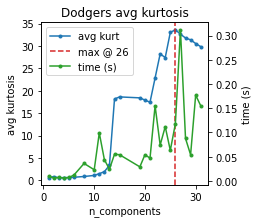

In [6]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
plt.title(f"{dataset_name} avg kurtosis")
plt.ylabel("avg kurtosis")
plt.xlabel("n_components")
ax.plot(list(avg_kurtosis.keys()), list(avg_kurtosis.values()), marker='.', label="avg kurt")
plt.axvline(max_avg_kurtosis_n_components, label=f"max @ {max_avg_kurtosis_n_components}", c="C3", linestyle='--')

ax2=plt.twinx()
ax2.plot(list(times.keys()), list(times.values()), c="C2", marker='.', label="time (s)")
ax2.set_ylabel("time (s)")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper left")

plt.show()

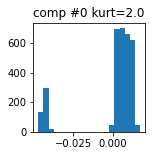

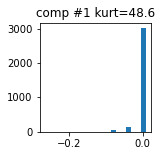

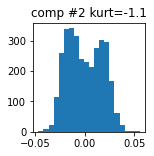

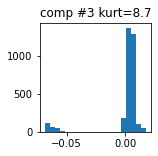

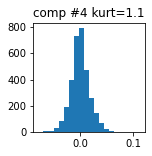

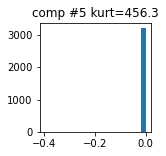

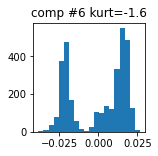

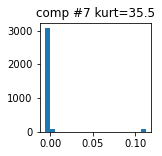

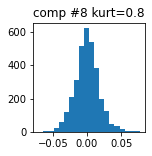

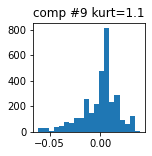

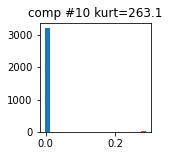

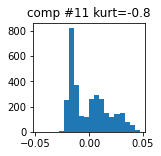

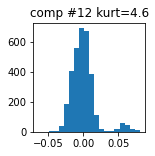

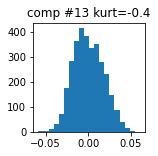

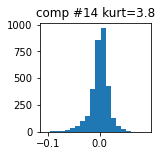

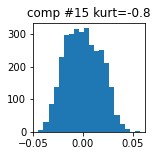

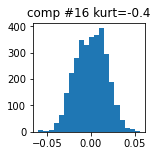

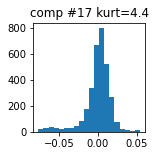

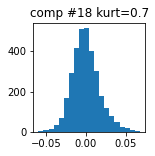

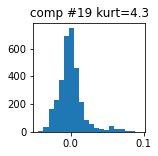

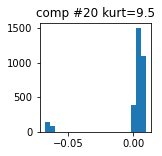

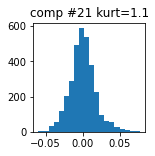

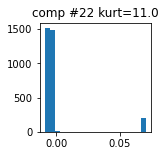

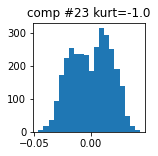

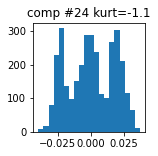

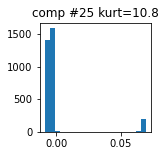

In [7]:
component_i = 0
above_avg_cols = []
below_avg_cols = []
#max_avg_kurtosis_n_components = 8

#for column in icas[max_avg_kurtosis_n_components].components_:
for column in X_train_transformeds[max_avg_kurtosis_n_components].T:
    #print(kurtosis(column))
    fig = plt.figure(figsize=(2,2))
    plt.title(f"comp #{component_i} kurt={kurtosis(column):.1f}")
    plt.hist(column, bins=20)
    plt.show()
    #if abs(kurtosis(column)) > 1:
    if abs(kurtosis(column)) > avg_kurtosis[max_avg_kurtosis_n_components]*0.1:
        above_avg_cols.append(component_i)
    else:
        below_avg_cols.append(component_i)
    
    component_i += 1


In [8]:
above_avg_cols

[1, 3, 5, 7, 10, 12, 14, 17, 19, 20, 22, 25]

In [9]:
len(above_avg_cols)

12

In [10]:
below_avg_cols

[0, 2, 4, 6, 8, 9, 11, 13, 15, 16, 18, 21, 23, 24]

In [11]:
best_model = icas[max_avg_kurtosis_n_components]

X_train_transformed = pd.DataFrame(X_train_transformeds[max_avg_kurtosis_n_components])
X_test_transformed = pd.DataFrame(best_model.transform(X_test))

for col in below_avg_cols:
    X_train_transformed[col].values[:] = 0
    X_test_transformed[col].values[:] = 0

X_train_inverse = pd.DataFrame(best_model.inverse_transform(X_train_transformed))
X_train_inverse.to_csv(f"output/{dataset_name}/ica-train-transformed.csv")

X_test_inverse = pd.DataFrame(best_model.inverse_transform(X_test_transformed))
X_test_inverse.to_csv(f"output/{dataset_name}/ica-test-transformed.csv")

In [12]:
pd.DataFrame(X_train_transformeds[max_avg_kurtosis_n_components])

0         1    2         3    4         5    6         7    8    9   \
0     0.0  0.003453  0.0 -0.064169  0.0  0.001032  0.0 -0.001360  0.0  0.0   
1     0.0  0.001993  0.0  0.003989  0.0  0.000955  0.0 -0.003004  0.0  0.0   
2     0.0  0.006856  0.0  0.003990  0.0  0.001310  0.0 -0.002460  0.0  0.0   
3     0.0  0.002023  0.0  0.002633  0.0  0.001624  0.0 -0.003999  0.0  0.0   
4     0.0  0.004702  0.0  0.003788  0.0  0.000615  0.0 -0.000460  0.0  0.0   
...   ...       ...  ...       ...  ...       ...  ...       ...  ...  ...   
3216  0.0  0.007297  0.0  0.004881  0.0  0.000803  0.0 -0.003876  0.0  0.0   
3217  0.0  0.002019  0.0  0.001146  0.0  0.001423  0.0 -0.001605  0.0  0.0   
3218  0.0  0.002529  0.0  0.014416  0.0  0.000817  0.0 -0.004534  0.0  0.0   
3219  0.0 -0.037402  0.0  0.004983  0.0 -0.000733  0.0 -0.001734  0.0  0.0   
3220  0.0  0.005630  0.0 -0.063458  0.0  0.001301  0.0 -0.001395  0.0  0.0   

      ...   16        17   18        19        20   21        22   23   24  \
0     ...  0.0  0.014078  0.0  0.008977  0.001371  0.0 -0.001942  0.0  0.0   
1     ...  0.0  0.000521  0.0 -0.007733  0.006072  0.0 -0.004644  0.0  0.0   
2     ...  0.0  0.028890  0.0 -0.005863  0.004622  0.0 -0.003467  0.0  0.0   
3     ...  0.0 -0.000987  0.0 -0.008186  0.007188  0.0 -0.005678  0.0  0.0   
4     ...  0.0  0.026526  0.0  0.009125 -0.066991  0.0 -0.003085  0.0  0.0   
...   ...  ...       ...  ...       ...       ...  ...       ...  ...  ...   
3216  ...  0.0  0.005340  0.0  0.011279  0.005656  0.0 -0.006035  0.0  0.0   
3217  ...  0.0 -0.004081  0.0 -0.003309  0.002501  0.0 -0.003278  0.0  0.0   
3218  ...  0.0  0.008744  0.0 -0.007175  0.006530  0.0 -0.005514  0.0  0.0   
3219  ...  0.0 -0.034413  0.0  0.000782 -0.066173  0.0 -0.002621  0.0  0.0   
3220  ...  0.0  0.003415  0.0  0.001962  0.002962  0.0 -0.002859  0.0  0.0   

            25  
0    -0.002376  
1    -0.004394  
2    -0.003198  
3    -0.005902  
4    -0.004671  
...        ...  
3216 -0.005477  
3217 -0.003789  
3218 -0.004916  
3219 -0.002159  
3220 -0.002565  

[3221 rows x 26 columns]

In [13]:
X_train_transformed

0         1    2         3    4         5    6         7    8    9   \
0     0.0  0.003453  0.0 -0.064169  0.0  0.001032  0.0 -0.001360  0.0  0.0   
1     0.0  0.001993  0.0  0.003989  0.0  0.000955  0.0 -0.003004  0.0  0.0   
2     0.0  0.006856  0.0  0.003990  0.0  0.001310  0.0 -0.002460  0.0  0.0   
3     0.0  0.002023  0.0  0.002633  0.0  0.001624  0.0 -0.003999  0.0  0.0   
4     0.0  0.004702  0.0  0.003788  0.0  0.000615  0.0 -0.000460  0.0  0.0   
...   ...       ...  ...       ...  ...       ...  ...       ...  ...  ...   
3216  0.0  0.007297  0.0  0.004881  0.0  0.000803  0.0 -0.003876  0.0  0.0   
3217  0.0  0.002019  0.0  0.001146  0.0  0.001423  0.0 -0.001605  0.0  0.0   
3218  0.0  0.002529  0.0  0.014416  0.0  0.000817  0.0 -0.004534  0.0  0.0   
3219  0.0 -0.037402  0.0  0.004983  0.0 -0.000733  0.0 -0.001734  0.0  0.0   
3220  0.0  0.005630  0.0 -0.063458  0.0  0.001301  0.0 -0.001395  0.0  0.0   

      ...   16        17   18        19        20   21        22   23   24  \
0     ...  0.0  0.014078  0.0  0.008977  0.001371  0.0 -0.001942  0.0  0.0   
1     ...  0.0  0.000521  0.0 -0.007733  0.006072  0.0 -0.004644  0.0  0.0   
2     ...  0.0  0.028890  0.0 -0.005863  0.004622  0.0 -0.003467  0.0  0.0   
3     ...  0.0 -0.000987  0.0 -0.008186  0.007188  0.0 -0.005678  0.0  0.0   
4     ...  0.0  0.026526  0.0  0.009125 -0.066991  0.0 -0.003085  0.0  0.0   
...   ...  ...       ...  ...       ...       ...  ...       ...  ...  ...   
3216  ...  0.0  0.005340  0.0  0.011279  0.005656  0.0 -0.006035  0.0  0.0   
3217  ...  0.0 -0.004081  0.0 -0.003309  0.002501  0.0 -0.003278  0.0  0.0   
3218  ...  0.0  0.008744  0.0 -0.007175  0.006530  0.0 -0.005514  0.0  0.0   
3219  ...  0.0 -0.034413  0.0  0.000782 -0.066173  0.0 -0.002621  0.0  0.0   
3220  ...  0.0  0.003415  0.0  0.001962  0.002962  0.0 -0.002859  0.0  0.0   

            25  
0    -0.002376  
1    -0.004394  
2    -0.003198  
3    -0.005902  
4    -0.004671  
...        ...  
3216 -0.005477  
3217 -0.003789  
3218 -0.004916  
3219 -0.002159  
3220 -0.002565  

[3221 rows x 26 columns]

In [14]:
# X_train_transformed = pd.DataFrame(X_train_transformeds[max_avg_kurtosis_n_components])
# X_train_transformed = X_train_transformed.loc[:, above_avg_cols]

# X_test_transformed = pd.DataFrame(icas[max_avg_kurtosis_n_components].transform(X_test))
# X_test_transformed = X_test_transformed.loc[:, above_avg_cols]

In [15]:
# X_train_transformed.to_csv(f"output/{dataset_name}/ica-train-transformed.csv")
# X_test_transformed.to_csv(f"output/{dataset_name}/ica-test-transformed.csv")

In [16]:
# pd.DataFrame(icas[max_avg_kurtosis_n_components].inverse_transform(X_train_transformeds[max_avg_kurtosis_n_components])).to_csv(f"output/{dataset_name}/ica-train-transformed.csv")
# pd.DataFrame(icas[max_avg_kurtosis_n_components].inverse_transform(pd.DataFrame(icas[max_avg_kurtosis_n_components].transform(X_test)))).to_csv(f"output/{dataset_name}/ica-test-transformed.csv")

In [17]:
# pearsonr(X_train_transformeds[max_avg_kurtosis_n_components].T[2], X_train["volatile acidity"])


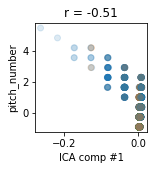

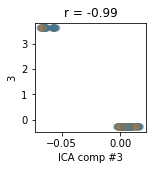

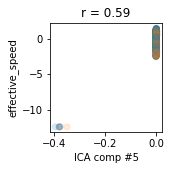

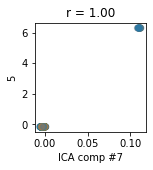

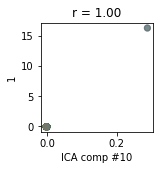

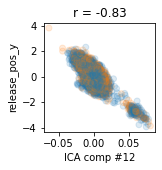

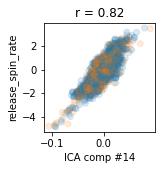

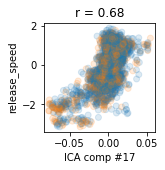

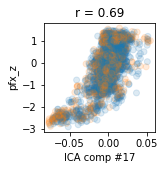

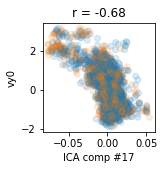

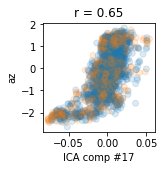

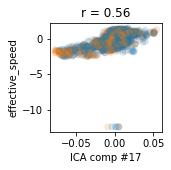

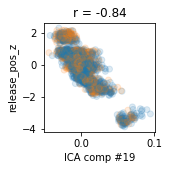

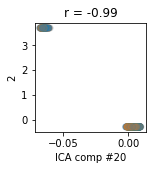

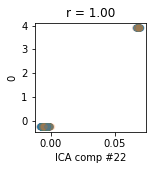

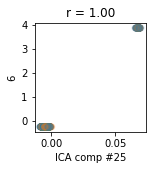

In [19]:
colors = {"ball":'C0', "called_strike":'C1', 'red':'C1', 'white':'C0'}
c = [colors[val] for val in y_train]
for comp_i in above_avg_cols:
    for orig_feature_i in range(X_train.shape[1]):
        fig = plt.figure(figsize=(2,2))
        X = X_train_transformeds[max_avg_kurtosis_n_components].T[comp_i]
        Y = X_train.iloc[:,orig_feature_i]
        r = pearsonr(X, Y)[0]
        plt.scatter(X, Y, c=c, alpha=0.15)
        plt.title(f"r = {r:.2f}")
        plt.xlabel(f"ICA comp #{comp_i}")
        plt.ylabel(X_train.columns[orig_feature_i])
        if abs(r) > 0.5:
            plt.show()
        else:
            plt.close()

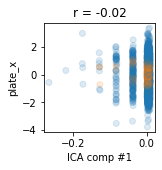

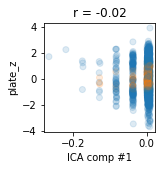

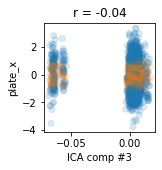

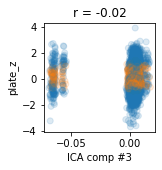

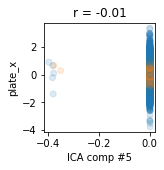

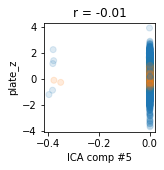

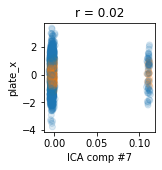

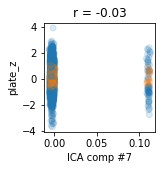

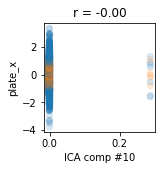

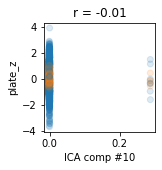

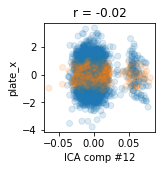

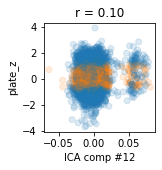

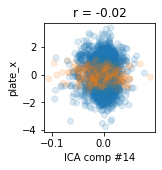

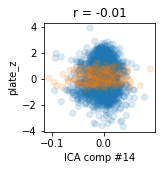

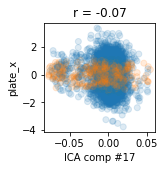

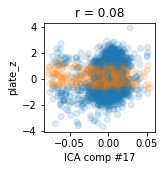

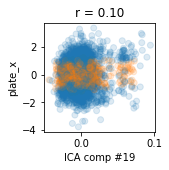

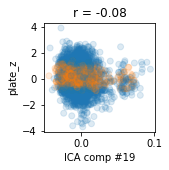

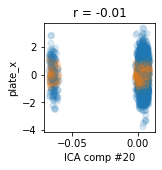

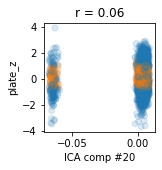

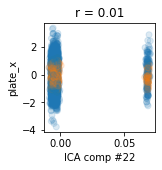

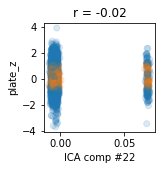

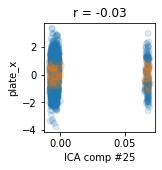

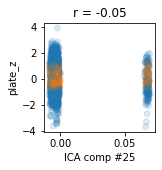

In [25]:
# colors = {"ball":'C0', "called_strike":'C1', 'red':'C1', 'white':'C0'}
# c = [colors[val] for val in y_train]
# for comp_i in above_avg_cols:
#     for orig_feature_i in ["plate_x", "plate_z"]:
#         fig = plt.figure(figsize=(2,2))
#         X = X_train_transformeds[max_avg_kurtosis_n_components].T[comp_i]
#         Y = X_train[orig_feature_i]
#         r = pearsonr(X, Y)[0]
#         plt.scatter(X, Y, c=c, alpha=0.15)
#         plt.title(f"r = {r:.2f}")
#         plt.xlabel(f"ICA comp #{comp_i}")
#         plt.ylabel(orig_feature_i)
#         if abs(r) > 0.0:
#             plt.show()
#         else:
#             plt.close()